In [371]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim
import torch.nn as nn
import kymatio.datasets as scattering_datasets
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import os, sys
opj = os.path.join
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
from transforms_torch import bandpass_filter
sys.path.append('../../dsets/mnist')
import dset
from model import Net
from util import *
from numpy.fft import *
from torch import nn
from style import *
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
from model import Net, Net2c
from kymatio import Scattering2D
from kymatio.scattering2d.filter_bank import filter_bank
from scipy.fftpack import fft2
from colorsys import hls_to_rgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [411]:
M = 256
N = 256
J = 3
L = 8
batch_size = 128
scattering = Scattering2D(J, shape=(M, N), L=L, max_order=2)
filters_set = filter_bank(M, N, J, L=L)

In [412]:
# test image
x = torch.randn(batch_size, 3, M, N, dtype=torch.float32)

if device == 'cuda':
    scattering.cuda()
    x = x.cuda()
    
Sx = scattering.forward(x) 

In [413]:
Sx.shape

torch.Size([128, 3, 217, 32, 32])

In [244]:
def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0/(1.0 + abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a, b in zip(A, B)]
    return c

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


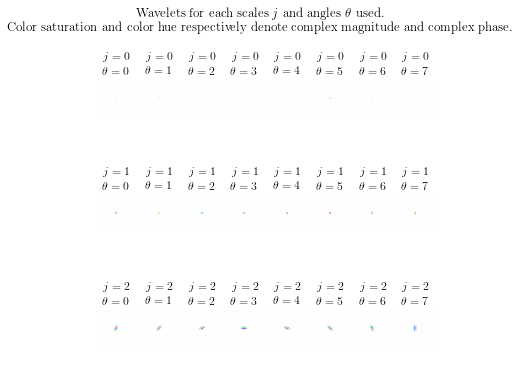

In [323]:
# bandpass filters
fig, axs = plt.subplots(J, L, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(6)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
i = 0
for filter in filters_set['psi']:
    f = filter[0][..., 0]
#     filter_c = torch.rfft(f, 2, onesided=False)
    filter_c = fft2(f.numpy())
    filter_c = np.fft.fftshift(filter_c)
    axs[i // L, i % L].imshow(colorize(filter_c))
    axs[i // L, i % L].axis('off')
    axs[i // L, i % L].set_title(
        "$j = {}$ \n $\\theta={}$".format(i // L, i % L))
    i = i+1

fig.suptitle((r"Wavelets for each scales $j$ and angles $\theta$ used."
              "\nColor saturation and color hue respectively denote complex "
              "magnitude and complex phase."), fontsize=13)
fig.show()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


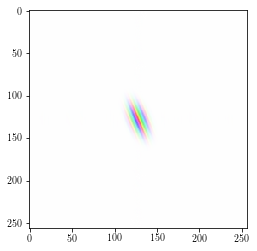

In [363]:
f = filters_set['psi'][-2][0][..., 0]
#     filter_c = torch.rfft(f, 2, onesided=False)
filter_c = fft2(f.numpy())
filter_c = np.fft.fftshift(filter_c)
plt.imshow(colorize(filter_c))


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


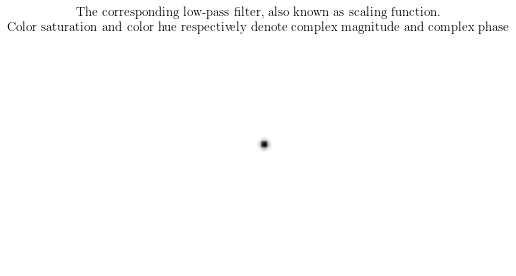

In [288]:
# low pass filter
plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.axis('off')
plt.set_cmap('gray_r')

f = filters_set['phi'][0][..., 0]

filter_c = fft2(f.numpy())
filter_c = np.fft.fftshift(filter_c)
plt.suptitle(("The corresponding low-pass filter, also known as scaling "
              "function.\nColor saturation and color hue respectively denote "
              "complex magnitude and complex phase"), fontsize=13)
filter_c = np.abs(filter_c)
plt.imshow(filter_c)

plt.show()

# Classification CNN

In [506]:
class Scattering2dCNN(nn.Module):
    '''
        Simple CNN with 3x3 convs 
    '''
    def __init__(self, in_channels, scattering):
        super(Scattering2dCNN, self).__init__()
        self.in_channels = in_channels
        self.scattering = scattering
        self.conv2 = nn.Conv2d(self.in_channels, 20, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.pool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
#         self.fc1 = nn.Linear(80, 50)
        self.fc1 = nn.Linear(180, 50)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(50, 10)        

    def forward(self, x):
        x = scattering(x).view(-1, self.in_channels, 7, 7)
        x = self.relu2(self.pool2(self.conv2_drop(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)        
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [507]:
# scattering obj
scattering = Scattering2D(J=2, shape=(28, 28), max_order=1)
scattering.cuda()

in_channels = 17
model_sc = Scattering2dCNN(in_channels, scattering).to(device)
# model_sc.load_state_dict(torch.load('./models/scattering/mnist.scattering.model'))
# model_sc.eval()
# test(model_sc, device, test_loader, scattering)

# data_loader
args = dset.get_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
train_loader, test_loader = dset.load_data(train_batch_size=64, test_batch_size=1000, device=device)

# load the model
model = Net().to(device)
model.load_state_dict(torch.load('../../dsets/mnist/mnist.model', map_location=device))
model = model.eval()
dset.test(model, test_loader, args)


Test set: Average loss: 0.0735, Accuracy: 9772/10000 (97.72%)



In [508]:
# Optimizer
lr = 0.01
for epoch in range(0, 50):
    optimizer = torch.optim.SGD(model_sc.parameters(), lr=lr, momentum=0.5)
    train(model_sc, device, train_loader, optimizer, epoch+1)
    test(model_sc, device, test_loader)
torch.save(model_sc.state_dict(), './models/scattering/mnist.scattering.model')

Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.441697
Test set: Average loss: 1.0434, Accuracy: 7829/10000 (78.29%)

Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.951974
Test set: Average loss: 0.4055, Accuracy: 8992/10000 (89.92%)

Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.588086
Test set: Average loss: 0.2526, Accuracy: 9303/10000 (93.03%)

Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.506993
Test set: Average loss: 0.1946, Accuracy: 9436/10000 (94.36%)

Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.511574
Test set: Average loss: 0.1624, Accuracy: 9527/10000 (95.27%)

Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.553941
Test set: Average loss: 0.1395, Accuracy: 9573/10000 (95.73%)

Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.494178
Test set: Average loss: 0.1239, Accuracy: 9616/10000 (96.16%)

Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.494505
Test set: Average loss: 0.1138, Accuracy: 9636/10000 (96.36%)

Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.397322
Test set: Average loss: 0.1009, Accuracy: 9671